# Basic Usage
Here you can learn how to use this package as a python library. You can create simulations, run routing, congestion simulations and other analytics from here.

## Prerequisites

Things you need to define before you can run all the simulation:
- Place name of the format (for example 'Eindhoven, Netherlands')
- The url to the Geofabrik OSM repository for the smallest region covering the place
- The url to the Transitfeed place
- The date and time of the pivot date (specifies the time where the graph will be built. Note, that the corresponding OSM and GTFS data must be available at this time)
- The amount of RAM that can be used to build the graph and run routing (in GB, requirements vary by graph size)
- The amount of threads to use for routing
- The amount of virtual commuters to simulate
- Whether to use delay simulation (you need to setup other data for this)

In [1]:
from datetime import datetime, timezone

place_name = 'Eindhoven, Netherlands'
geofabrik_url = 'https://download.geofabrik.de/europe/netherlands/noord-brabant.html'
transitfeed_url = 'https://transitfeeds.com/l/194-the-netherlands'
pivot_date = datetime(2022, 10, 4, 8, 0, 0, 0, tzinfo=None)
ram_gb = 12
num_threads = 6
num_virtual_commuters = 2000
use_delay_simulation = False

## Load a Place

First, we will load the place. Currently, a bit inconvinient. we plan to streamline this process in the future. First, we load the demographics data.

In [2]:
import hiveline
db = hiveline.get_database()

place = hiveline.Place(place_name)
place.load_all()

Data found in db
Data found in db
Data found in db
Data found in db


Add the place to the database. This will create a new place (or update it) as well as the corresponding tile data.

In [3]:
place.export_place_to_mongo()
place.export_tiles_to_mongo()

C:\projects\mobility\hiveline\hiveline\od\place.py:400: UserWarning: Geometry column does not contain geometry.
  id_df['geometry'] = id_df['geometry'].astype(str)


Now we can get the place_id and index the OSM and GTFS data for routing. Note that this may scrape the data from the corresponding websites.

In [4]:
place_id = hiveline.get_place_id(db, place_name)
place_resources = hiveline.create_place_resources(geofabrik_url, transitfeed_url, place_name, place_id, db, skip_existing=True)

## Build OTP Graph

Next, we will prepare OpenTripPlanner. This will download any necessary files and build the graph for the pivot date. This may take a while. 

Note, that once you built the graph for one place and time, it will be stored in the cache and you can reuse it later. The build graph function will skip building in this case.

Also note, that OTP's output is printed to the jupyter console. If the building process fails, it can help to look into the jupyter console output to find the reason.

In [5]:
hiveline.build_graph(place_resources, pivot_date, force_rebuild=False, memory_gb=ram_gb)

Cleaned up graph file
{'date': datetime.datetime(2023, 1, 2, 3, 17), 'link': 'https://download.geofabrik.de/europe/netherlands/noord-brabant-230101.osm.pbf'}
{'date': datetime.datetime(2022, 9, 28, 0, 0), 'link': 'https://transitfeeds.com/p/ov/814/20220928/download'}
OSM resource: {'file': 'C:/projects/mobility/hiveline/hiveline/routing/data/09c316cdcf1d5d4a6e39c31dd92144468b52c6b5dae10d7d41533455810da631.pbf', 'source': 'https://download.geofabrik.de/europe/netherlands/noord-brabant-230101.osm.pbf', 'date': datetime.datetime(2023, 1, 2, 3, 17)}
GTFS resources: [{'file': 'C:/projects/mobility/hiveline/hiveline/routing/data/c17f8478f6b7d21b5d8a8f804263af863e46b55c612de0fd261f1cbf5cc8f67a.gtfs.zip', 'source': 'https://transitfeeds.com/p/ov/814/20220928/download', 'date': datetime.datetime(2022, 9, 28, 0, 0), 'provider': 'OV // OVapi GTFS '}]
Graph already built


{'otp_version': '2.4.0',
 'graph_file': 'C:/projects/mobility/hiveline/hiveline/routing/data/6568bc0d8d4d2057c14a85dd-2022-10-04T080000-graph.obj',
 'osm_source': {'file': 'C:/projects/mobility/hiveline/hiveline/routing/data/09c316cdcf1d5d4a6e39c31dd92144468b52c6b5dae10d7d41533455810da631.pbf',
  'source': 'https://download.geofabrik.de/europe/netherlands/noord-brabant-230101.osm.pbf',
  'date': datetime.datetime(2023, 1, 2, 3, 17)},
 'gtfs_sources': [{'file': 'C:/projects/mobility/hiveline/hiveline/routing/data/c17f8478f6b7d21b5d8a8f804263af863e46b55c612de0fd261f1cbf5cc8f67a.gtfs.zip',
   'source': 'https://transitfeeds.com/p/ov/814/20220928/download',
   'date': datetime.datetime(2022, 9, 28, 0, 0),
   'provider': 'OV // OVapi GTFS '}]}

## Create and Run Simulation

Now that all data is loaded into the database and built locally, we can create a simulation. This will create a new simulation in the database and create a set of virtual commuters

In [6]:
sim_id = hiveline.create_simulation(place_name, pivot_date, num_virtual_commuters, db=db, use_parking=False)

Simulation inserted to mongo
Data found in db
Data found in db
Data found in db
Data found in db
Data not in db, computing
Data not in db, computing
Data not in db, computing
Data not in db, computing
Data not in db, computing
Generating 2000 virtual commuters


After creating a simulation, we can run routing on it. This will use OTP to route all virtual commuters and store the results in the database. This may take a while.

In [7]:
hiveline.route_virtual_commuters(sim_id, use_delays=use_delay_simulation, graph_build_memory=ram_gb, server_memory=ram_gb, num_threads=num_threads, reset_jobs=True)

[WRAPPER] Running routing algorithm for sim_id 777486f9-1038-44ea-86a2-12969a83f242
[WRAPPER] Routing algorithm for sim_id 777486f9-1038-44ea-86a2-12969a83f242 finished


## Analyze Simulation

Now that we have all routes, we can analyze them. There are a lot of plotting an analysis methods available. Here are some examples:

In [8]:
stats = hiveline.get_sim_stats(sim_id, db=db)

In [9]:
print(hiveline.get_all_modal_shares(stats))

{'car_share': 0.2624388323559755, 'rail_share': 0.0, 'bus_share': 0.0028719068527416534, 'walk_share': 0.7346892607912829}


In [10]:
print(hiveline.get_transit_modal_share(stats))  # transit vs car modal share

0.010824691308414602


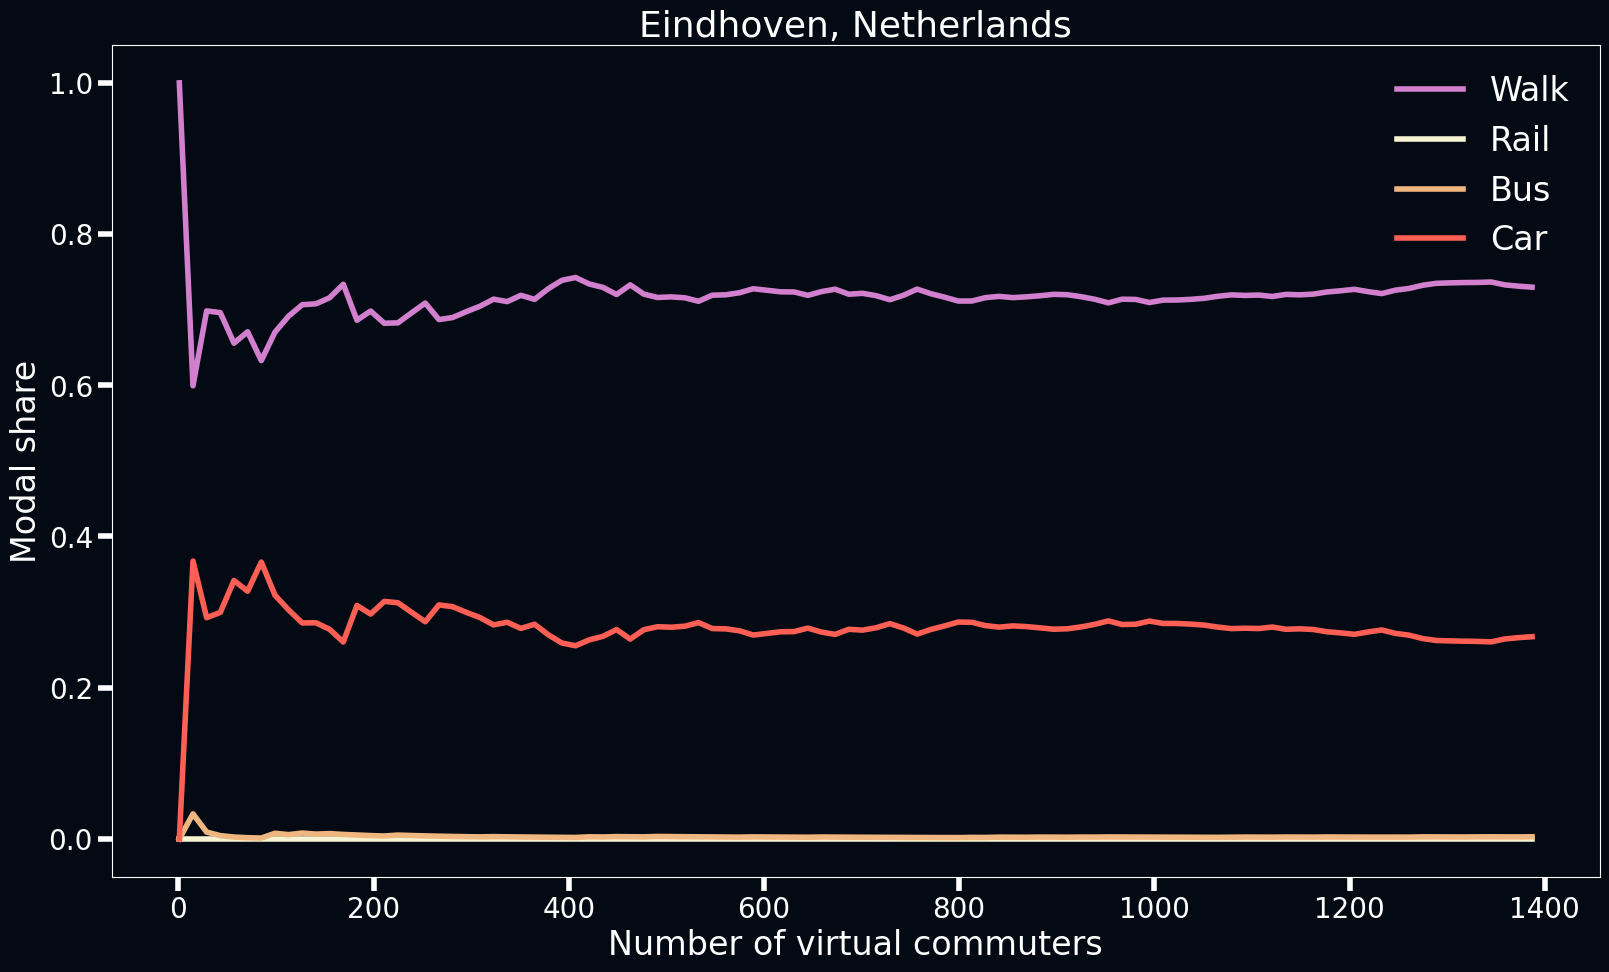

In [11]:
hiveline.plot_monte_carlo_convergence(sim_id, db=db, city_name=place_name)